In [1]:
!git clone https://github.com/x3042/zsl_in_csr.git

Cloning into 'zsl_in_csr'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 31 (delta 9), reused 30 (delta 8), pack-reused 0
Unpacking objects: 100% (31/31), 5.38 KiB | 550.00 KiB/s, done.


In [68]:
import numpy as np
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
from random import randint, seed
import seaborn as sns
import scipy
from tqdm import tqdm
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [23]:
import pandas as pd
import keras


In [61]:
import numpy as np
import scipy

def corrupt(X, rate):
    m, n = X.shape
    rate = n * rate // 100
    ind_m = np.random.randint(m, size=rate)
    ind_n = np.random.randint(n, size=rate)

    for i, j in zip(ind_m, ind_n):
        X[i][j] = 0

    return X

def NormalizeFea(fea, row=1):
# % if row == 1, normalize each row of fea to have unit norm;
# % if row == 0, normalize each column of fea to have unit norm;

    norms = np.linalg.norm(fea, axis=row) + 0.00001
    if row == 0:
        return fea / norms
    else:
        return (fea.T / norms).T


def distCosine(x, y):
    xx = np.sum(x**2, axis=1)**0.5
    x = x / xx[:, np.newaxis]
    yy = np.sum(y**2, axis=1)**0.5
    y = y / yy[:, np.newaxis]
    dist = np.dot(x, y.transpose())
    return dist


def dist(S_est, S_te_gt):
    # INPUT:
    # % S_est: estimated semantic labels
    # % S_te_gt: ground truth semantic labels
    # % param: other parameters

    dist = 1 - distCosine(S_est, NormalizeFea(S_te_gt, 0))

    return dist.shape

from numpy import linalg

def get_norms(A, B):
  C = A-B
  a0 = np.mean(np.sqrt(np.sum(C * C, axis=0)))
  a1 = np.mean(np.sqrt(np.sum(C * C, axis=1)))
  return [linalg.norm(C), linalg.norm(C, 2), a0, a1]

In [29]:
#edited /content/PDBP-Fusion/predict.py

from keras.models import load_model
import numpy as np
from datetime import datetime
import tensorflow as tf
import numpy as np
import pdb

def get_nuq_concolutional_array(seq, str_len=201, RNA=False):
    alpha = 'ACGT'
    if RNA:
      alpha = 'ACGU'
    row = (len(seq))
    new_array = np.zeros((row, 4))

    for i, val in enumerate(seq):

        if val not in alpha:
            if val == 'Z':
                new_array[i] = np.array([0.0] * 4)
            # if val == 'S':
            #     new_array[i] = np.array([0, 0.5, 0.5, 0, 0])
            continue

        try:
            index = alpha.index(val)
            new_array[i][index] = 1
        except ValueError:
            pdb.set_trace()
    return new_array  

def get_seq_concolutional_array(seq): #from encode_schema.py
    # seq = seq.replace('U', 'T')
    alpha = 'ACDEFGHIKLMNPQRSTVWY'
    row = (len(seq))
    new_array = np.zeros((row, 20))

    for i, val in enumerate(seq):

        if val not in 'ACDEFGHIKLMNPQRSTVWY':
            if val == 'Z':
                new_array[i] = np.array([0.0] * 20)
            # if val == 'S':
            #     new_array[i] = np.array([0, 0.5, 0.5, 0, 0])
            continue

        try:
            index = alpha.index(val)
            new_array[i][index] = 1
        except ValueError:
            pdb.set_trace()
    return new_array

def read_seq_onehot(seq_file, str_len=600): #from encode_schema.py fix const 600 (was 850)
    seq_list = []
    seq = ''
    with open(seq_file, 'r') as fp:
        index = 0
        for line in fp:
            index += 1
            string = line
            if len(line)>=str_len:
                string=string[:str_len]
            else:
                string=string+'Z'*(str_len-len(string))
            
            assert len(string)==str_len
            line = string

            seq = line
            seq_array = get_seq_concolutional_array(seq)
            seq_list.append(seq_array)
        print(index)
    return np.array(seq_list, dtype=object)

def read_nuq_onehot(seq_file, str_len=201, RNA=False): 
    seq_list = []
    seq = ''
    with open(seq_file, 'r') as fp:
        index = 0
        for line in fp:
            index += 1
            string = line
            if len(line)>=str_len:
                string=string[:str_len]
            else:
                string=string+'Z'*(str_len-len(string))
            
            assert len(string)==str_len
            line = string

            seq = line
            seq_array = get_nuq_concolutional_array(seq,str_len=201, RNA=RNA)
            seq_list.append(seq_array)
        print(index)
    return np.array(seq_list, dtype=object)


class Pred():
    def __init__(self,model_path='./model_save/model_'):
        self.item_model_path = '/content/PDBP-Fusion/model_save/model_0.hdf5'
        #self.model = load_model(item_model_path)

    def sample_predict1(self,string,str_len=600):
        # make sure the input sequnce less than 850, otherwise drop string when length excell 850
        if len(string)>=str_len:
            string=string[:str_len]
        else:
            string=string+'Z'*(str_len-len(string))
        #print('len: ',str_len)
        assert len(string)==str_len

        #向量化
        #print(get_seq_concolutional_array(string)[:5,:])
        string_vector=get_seq_concolutional_array(string)
        string_vector=np.expand_dims(string_vector,0)

        #load model and predict
        result=[]
        self.model = load_model(self.item_model_path)
        predict=self.model.predict(string_vector)[0]
        print('prediction is {}'.format(predict))
        result.append(predict)
        print(result)

        return result

    def sample_predict(self,string,str_len=600):
        # make sure the input sequnce less than 850, otherwise drop string when length excell 850

        seq = read_seq_onehot(string)
        print(seq.shape)
        # seq = np.asarray(seq).astype(np.float32)
        # string_vector=get_seq_concolutional_array(string)
        # string_vector=np.expand_dims(string_vector,0)

        #load model and predict
        result=[]
        self.model = load_model(self.item_model_path)
        predict=self.model.predict(tf.convert_to_tensor(seq, dtype=tf.float32))
        print('prediction is {}'.format(predict))
        result.append(predict)

        return result

    def get_emb_prot(self, path, str_len=600):
        seq = read_seq_onehot(path, str_len)
        config = '{"class_name": "Model", "config": {"name": "DBP_CNN_model", "layers": [{"name": "input", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 600, 20], "dtype": "float32", "sparse": false, "name": "input"}, "inbound_nodes": []}, {"name": "conv1d_10", "class_name": "Conv1D", "config": {"name": "conv1d_10", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [9], "strides": [1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["input", 0, 0, {}]]]}, {"name": "max_pooling1d_10", "class_name": "MaxPooling1D", "config": {"name": "max_pooling1d_10", "trainable": true, "dtype": "float32", "strides": [2], "pool_size": [2], "padding": "valid", "data_format": "channels_last"}, "inbound_nodes": [[["conv1d_10", 0, 0, {}]]]}, {"name": "dropout_10", "class_name": "Dropout", "config": {"name": "dropout_10", "trainable": true, "dtype": "float32", "rate": 0.3, "noise_shape": null, "seed": null}, "inbound_nodes": [[["max_pooling1d_10", 0, 0, {}]]]}, {"name": "conv1d_11", "class_name": "Conv1D", "config": {"name": "conv1d_11", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [9], "strides": [1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["dropout_10", 0, 0, {}]]]}, {"name": "max_pooling1d_11", "class_name": "MaxPooling1D", "config": {"name": "max_pooling1d_11", "trainable": true, "dtype": "float32", "strides": [2], "pool_size": [2], "padding": "valid", "data_format": "channels_last"}, "inbound_nodes": [[["conv1d_11", 0, 0, {}]]]}, {"name": "dropout_11", "class_name": "Dropout", "config": {"name": "dropout_11", "trainable": true, "dtype": "float32", "rate": 0.3, "noise_shape": null, "seed": null}, "inbound_nodes": [[["max_pooling1d_11", 0, 0, {}]]]}, {"name": "bidirectional_6", "class_name": "Bidirectional", "config": {"name": "bidirectional_6", "trainable": true, "dtype": "float32", "layer": {"class_name": "LSTM", "config": {"name": "lstm_5", "trainable": true, "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 16, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": null, "bias_constraint": null, "dropout": 0.0, "recurrent_dropout": 0.0, "implementation": 2}}, "merge_mode": "concat"}, "inbound_nodes": [[["dropout_11", 0, 0, {}]]]}, {"name": "dropout_25", "class_name": "Dropout", "config": {"name": "dropout_25", "trainable": true, "dtype": "float32", "rate": 0.3, "noise_shape": null, "seed": null}, "inbound_nodes": [[["bidirectional_6", 0, 0, {}]]]}, {"name": "flatten_6", "class_name": "Flatten", "config": {"name": "flatten_6", "trainable": true, "dtype": "float32", "data_format": "channels_last"}, "inbound_nodes": [[["dropout_25", 0, 0, {}]]]}, {"name": "dense_11", "class_name": "Dense", "config": {"name": "dense_11", "trainable": true, "dtype": "float32", "units": 128, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["flatten_6", 0, 0, {}]]]}, {"name": "batch_normalization_5", "class_name": "BatchNormalization", "config": {"name": "batch_normalization_5", "trainable": true, "dtype": "float32", "axis": -1, "momentum": 0.99, "epsilon": 0.001, "center": true, "scale": true, "beta_initializer": {"class_name": "Zeros", "config": {}}, "gamma_initializer": {"class_name": "Ones", "config": {}}, "moving_mean_initializer": {"class_name": "Zeros", "config": {}}, "moving_variance_initializer": {"class_name": "Ones", "config": {}}, "beta_regularizer": null, "gamma_regularizer": null, "beta_constraint": null, "gamma_constraint": null}, "inbound_nodes": [[["dense_11", 0, 0, {}]]]}, {"name": "dropout_3", "class_name": "Dropout", "config": {"name": "dropout_3", "trainable": true, "dtype": "float32", "rate": 0.3, "noise_shape": null, "seed": null}, "inbound_nodes": [[["batch_normalization_5", 0, 0, {}]]]}, {"name": "dense_12", "class_name": "Dense", "config": {"name": "dense_12", "trainable": true, "dtype": "float32", "units": 2, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["dropout_3", 0, 0, {}]]]}], "input_layers": [["input", 0, 0]], "output_layers": [["dense_12", 0, 0]]}, "keras_version": "2.3.1", "backend": "tensorflow"}'
 
        model = keras.models.model_from_json(config)

        self.model = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output,
                                    name='model_EmbPr')
        predict = self.model.predict(tf.convert_to_tensor(seq, dtype=tf.float32))
        return predict

    def get_emb_dna(self, path, str_len=201):
        seq = read_nuq_onehot(path, str_len=201)
        print(seq.shape)
        result = []
        deepg4 = keras.models.load_model('/content/best_model.h5')
        self.model = tf.keras.Model(inputs=deepg4.input, outputs=deepg4.layers[-3].output,
                         name='model_EmbG4')
        predict = self.model.predict(tf.convert_to_tensor(seq, dtype=tf.float32))
        return predict

    def get_emb_rna(self, path, str_len=201):
        seq = read_nuq_onehot(path, str_len=201, RNA=True)
        print(seq.shape)
        result = []
        deepg4 = keras.models.load_model('/content/best_model.h5')

        self.model = tf.keras.Model(inputs=deepg4.input, outputs=deepg4.layers[-3].output,
                         name='model_EmbG4')
        predict = self.model.predict(tf.convert_to_tensor(seq, dtype=tf.float32))
        return predict


In [30]:
Pr = Pred()
DNAG4 = Pr.get_emb_dna('/content/Target_DNA_Sequence.txt')
RNAG4 = Pr.get_emb_rna('/content/Target_RNA_Sequence.txt')

107
(107, 201, 4)
4/4 [==============================] - 0s 15ms/step
60
(60, 201, 4)
2/2 [==============================] - 0s 21ms/step


In [32]:
Pr = Pred()
PRD = Pr.get_emb_prot('/content/prots_dna.txt')
PRR = Pr.get_emb_prot('/content/prots_rna.txt')

107
4/4 [==============================] - 1s 44ms/step
60
2/2 [==============================] - 1s 88ms/step


In [33]:
from sklearn.model_selection import train_test_split

X = np.concatenate([DNAG4, RNAG4])
S = np.concatenate([PRD, PRR])
X_train, X_test, S_train, S_test = train_test_split(X, S, test_size=0.2)

In [34]:
X.shape

(167, 100)

In [62]:
from scipy import linalg
X = X_train.T
S = S_train.T
X_c = corrupt(X.T, 5).T
X_с = NormalizeFea(X_c)

lam = 1
beta = 1
rank = 10

A = S @ S.T
B = lam * X @ X_c.T  # in original there is B = lambda * X_c*X_c'; but in the article B=lamXX^.T; X^ - corrupted
C = S @ X.T + lam * S @ X_c.T
k, _ = S.shape
U = 0

for i in range(10):

    W = linalg.solve_sylvester(A, B, C)
    V, _, _ = np.linalg.svd(W @ W.T, full_matrices=True)
    U = np.eye(k) - V[:, :rank+1] @ V[:, :rank+1].T
    A = S @ S.T + beta * U
    S_new = NormalizeFea(X_test) @ NormalizeFea(W).T
    print('dist V >> S', get_norms(S_new, S_test))

    X_new = NormalizeFea(S_test, 0) @ NormalizeFea(W)
    print('dist S >> V', get_norms(X_test, X_new))   


dist V >> S (6.34581, 4.568199, 0.47799215, 1.0706382)
dist S >> V (12.883455, 9.244229, 1.2024845, 2.1779122)
dist V >> S (9.259564629240941, 6.944774350133778, 0.6725663913364518, 1.5777652686440102)
dist S >> V (16.893024457783675, 13.415253382962446, 1.5492144534003587, 2.8326722326141756)


In [106]:
lams = [1e1, 1e5, 1e10]
betas = [1e1, 1e5, 1e10]
ranks = [5, 20, 40]

In [107]:
xtos = [ [ [[] for i in range(3)]for i in range(3)] for i in range(3)]
stox = [[ [[] for i in range(3)]for i in range(3)] for i in range(3)]

In [108]:

for l, lam in enumerate(lams):
  for b, bet in enumerate(betas):
    for r, ra in enumerate(ranks):
      X = X_train.T
      S = S_train.T
      X_c = corrupt(X.T, 5).T
      X_с = NormalizeFea(X_c)

      lam = l
      beta = b
      rank = r

      A = S @ S.T
      B = lam * X @ X_c.T  # in original there is B = lambda * X_c*X_c'; but in the article B=lamXX^.T; X^ - corrupted
      C = S @ X.T + lam * S @ X_c.T
      k, _ = S.shape
      U = 0
      for i in range(10):

        W = linalg.solve_sylvester(A, B, C)
        V, _, _ = np.linalg.svd(W @ W.T, full_matrices=True)
        U = np.eye(k) - V[:, :rank+1] @ V[:, :rank+1].T
        A = S @ S.T + beta * U
        S_new = NormalizeFea(X_test) @ NormalizeFea(W).T
        xtos[l][b][r].append(get_norms(S_new, S_test)) #[X >>> S]

        X_new = NormalizeFea(S_test, 0) @ NormalizeFea(W)
        stox[l][b][r].append(get_norms(X_test, X_new)) # [S >>> X


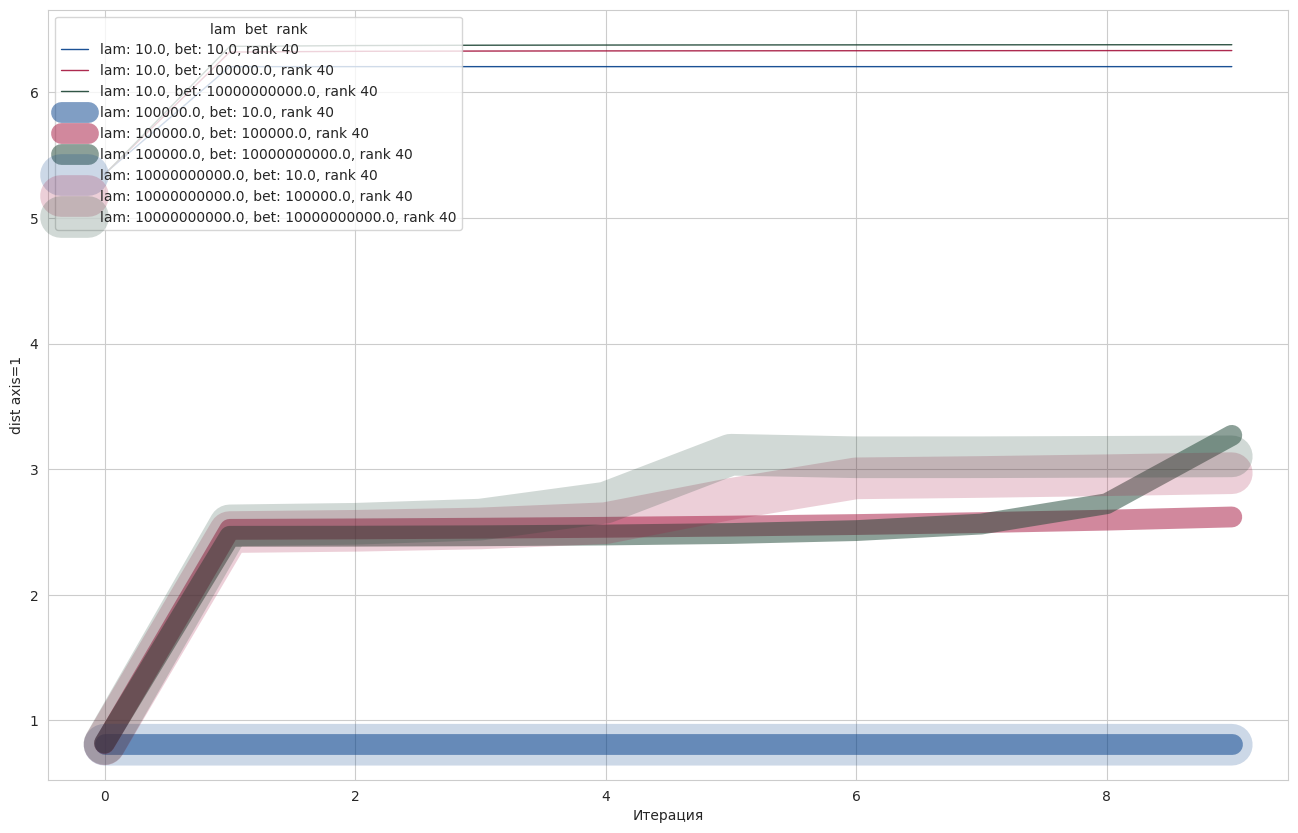

In [155]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16, 10))

pic_norm = 3 #  ["frob","2-norm", "dist axis=0", "dist axis=1"]

metrics = ["frob","2-norm", "dist axis=0", "dist axis=1"]
size = 15
alphas = [0.1, 1, 10]

col_gam = [['#03045e', '#023e8a', '#00b4d8'], ['#590d22', '#a4133c', '#ff4d6d'], ['#081c15', '#1b4332', '#52b788']]

for l, lam in enumerate(lams):
  for b, bet in enumerate(betas): 
    for r, ra in [(2, ranks[2])]:
           ns = [i[pic_norm] for i in xtos[l][b][r]]
           plt.plot(np.arange(10),
                    ns,
                    c=col_gam[b][1],
                    alpha=[0.9, 0.5, 0.2][l],
                    linewidth=[1, 15, 30][l],
                    label='lam: {}, bet: {}, rank {}'.format(lam, bet, ra))


plt.xlabel('Итерация')
plt.ylabel(metrics[pic_norm])
# plt.yscale('log')
# plt.xscale('log')
plt.legend(loc=2, title="lam  bet  rank")
plt.show()
fig.savefig("hyper_.png", format="png", dpi = 500, bbox_inches = 'tight')
 

In [194]:
def plot_exp(pic_norm, lams=[1e5, 1e7, 1e10], betas=[1e1, 1e5, 1e7],
             ranks = [5, 20, 40],
             ):
  
  xtos = [ [ [[] for i in range(3)]for i in range(3)] for i in range(3)]
  stox = [[ [[] for i in range(3)]for i in range(3)] for i in range(3)]

  for l, lam in enumerate(lams):
    for b, bet in enumerate(betas):
      for r, ra in enumerate(ranks):
        X = X_train.T
        S = S_train.T
        X_c = corrupt(X.T, 5).T
        X_с = NormalizeFea(X_c)

        lam = lam
        beta = bet
        rank = ra

        A = S @ S.T
        B = lam * X @ X_c.T  # in original there is B = lambda * X_c*X_c'; but in the article B=lamXX^.T; X^ - corrupted
        C = S @ X.T + lam * S @ X_c.T
        k, _ = S.shape
        U = 0
        for i in range(5):

          W = linalg.solve_sylvester(A, B, C)
          V, _, _ = np.linalg.svd(W @ W.T, full_matrices=True)
          U = np.eye(k) - V[:, :rank+1] @ V[:, :rank+1].T
          A = S @ S.T + beta * U
          S_new = NormalizeFea(X_test) @ NormalizeFea(W).T
          xtos[l][b][r].append(get_norms(S_new, S_test)) #[X >>> S]

          X_new = NormalizeFea(S_test, 0) @ NormalizeFea(W)
          stox[l][b][r].append(get_norms(X_test, X_new)) # [S >>> X]

  sns.set_style("whitegrid")
  fig = plt.figure(figsize=(16, 10))

  #  ["frob","2-norm", "dist axis=0", "dist axis=1"]

  metrics = ["frob","2-norm", "dist axis=0", "dist axis=1"]
  size = 15
  alphas = [0.1, 1, 10]

  col_gam = [['#03045e', '#023e8a', '#00b4d8'], ['#590d22', '#a4133c', '#ff4d6d'], ['#081c15', '#1b4332', '#52b788']]

  for l, lam in enumerate(lams):
    for b, bet in enumerate(betas): 
      for r, ra in enumerate(ranks):
            ns = [i[pic_norm] for i in stox[l][b][r]]
            plt.plot(np.arange(5),
                      ns,
                      c=col_gam[b][1],
                      alpha=[0.9, 0.5, 0.2][l],
                      linewidth=[1, 15, 30][r],
                      label='lam: {}, bet: {}, rank {}'.format(lam, bet, ra))


  plt.xlabel('Итерация')
  plt.ylabel(metrics[pic_norm])
  # plt.yscale('log')
  # plt.xscale('log')
  plt.legend(loc=2, title="lam  bet  rank")
  plt.show()
  fig.savefig("hyper_{}.png".format(metrics[pic_norm]), format="png", dpi = 500, bbox_inches = 'tight')
  


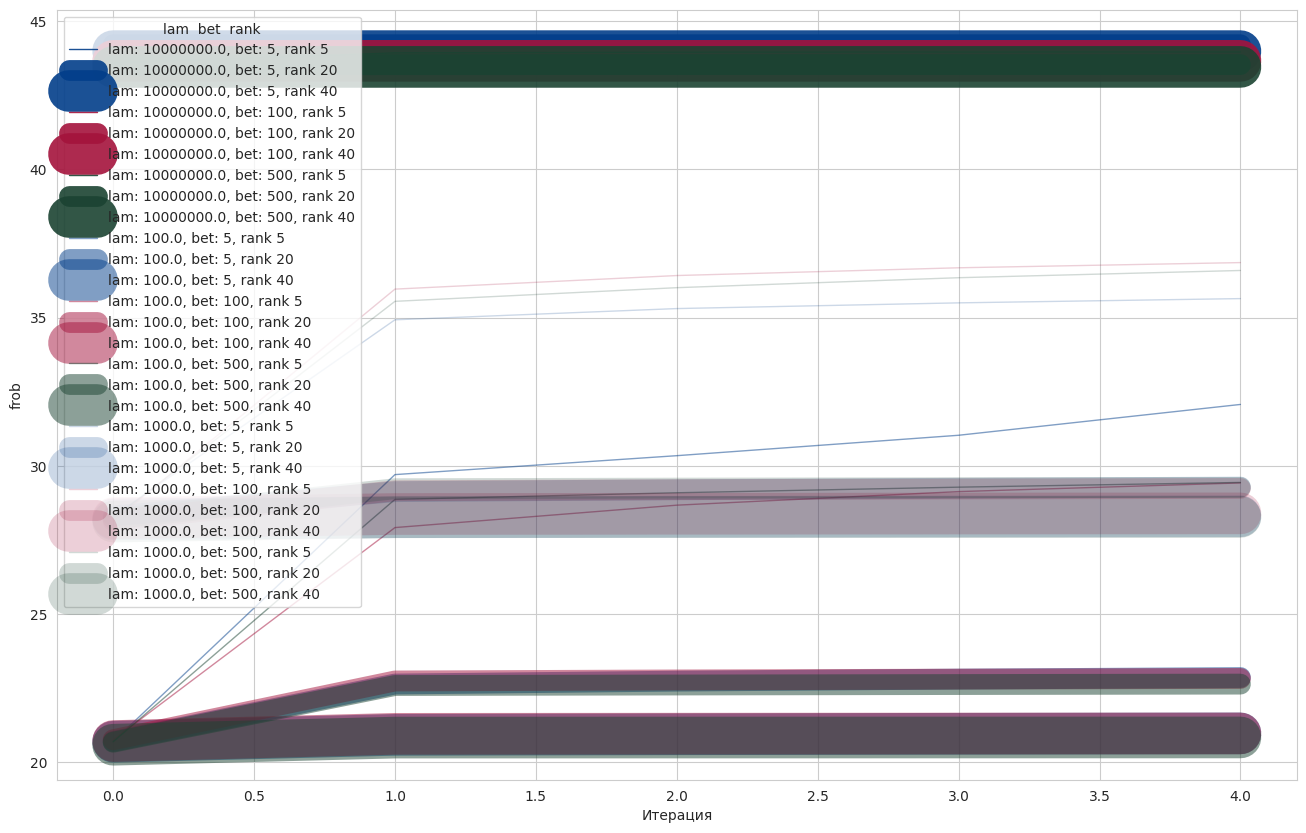

In [198]:
plot_exp(0, lams=[1e7, 1e2, 1e3], betas=[5, 100, 500])